In [39]:
pip install -q pandas matplotlib scikit-learn transformers tensorflow==2.16.1 tf-keras

Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'your_file.csv' with the path to your CSV file
df = pd.read_csv('combined_dfv2.csv', dtype=str)

df = df.dropna(subset=['max_predicted_aspect', 'Combined Text'])

filtered_df = df[df['Month of Response Date'] == 'Apr-24']
filtered_df['max_predicted_aspect'] = filtered_df['max_predicted_aspect'].replace({'Product/print quality': 'Quality'})
df_prep = filtered_df

df_prep.head(3)

C:\Users\royle\AppData\Local\Temp\ipykernel_5764\3178984877.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['max_predicted_aspect'] = filtered_df['max_predicted_aspect'].replace({'Product/print quality': 'Quality'})


,Survey ID,Product Name,Print Customer Region,LTR,Source Type,Survey language,Review Source,Star Rating,Product Family,Supplies Family,...,Model Name,Combined Text,Ink Supply Type,token_count,Month of Response Date,predicted_level1,predicted_probabilities,max_predicted_probability,max_predicted_level1,max_predicted_aspect
18,110020182,HP 63 Black Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Dolmen Refresh,...,HP 63 Black Original Ink Cartridge,"Excllent quality; easy to order, received prom...",IPH,7,Apr-24,"Logistic Handling, General satisfied","['0.8352197918762199', '0.7786848755893012']",0.880666667,Brand Loyalty,Others
108,123460320,HP 65XL Black Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Dolmen Refresh,...,HP 65XL Black Original Ink Cartridge,Great price and arrived even earlier than stated.,IPH,8,Apr-24,Logistic Handling,['0.7908739113381595'],0.796588235,Brand Loyalty,Others
137,132417974,HP 65XL Black Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Dolmen Refresh,...,HP 65XL Black Original Ink Cartridge,Ink gets used up way to quickly for the price ...,IPH,40,Apr-24,Others,['0'],0.903254902,Brand Loyalty,Others


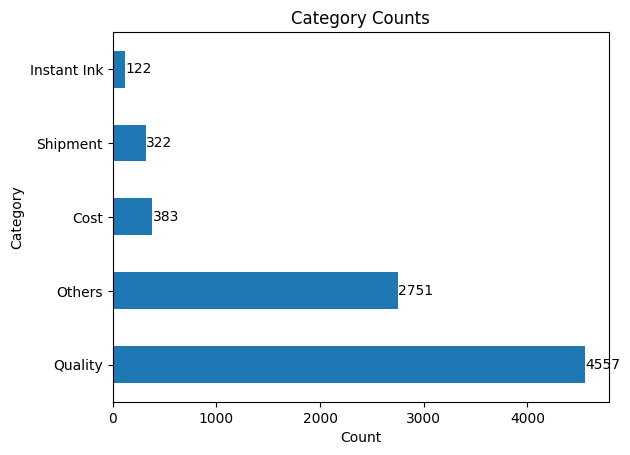

In [21]:
value_counts = filtered_df['max_predicted_aspect'].value_counts()

# Plot horizontal bar chart
ax = value_counts.plot(kind='barh')

# Add data labels on the bars
for i in ax.containers:
    ax.bar_label(i)

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Category Counts')

# Show the plot
plt.show()


In [29]:
# Combined Text
# max_predicted_aspect

df_prep['encoded_cat'] = df_prep['max_predicted_aspect'].astype('category').cat.codes

data_texts = df_prep['Combined Text'].to_list() # Features (not tokenized yet)
data_labels = df_prep['encoded_cat'].to_list() # Labels

C:\Users\royle\AppData\Local\Temp\ipykernel_5764\1726889107.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prep['encoded_cat'] = df_prep['max_predicted_aspect'].astype('category').cat.codes


In [30]:
from sklearn.model_selection import train_test_split
 
# Split Train and Validation data
# train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0, shuffle=True)

# # 100% of Data for training
train_texts = data_texts
train_labels = data_labels
val_texts = data_texts
val_labels = data_labels
 
# Keep some data for inference (testing)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0, shuffle=True)

###############################################################################################################################################

from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
import pandas as pd


tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

# Create TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings),val_labels))

# TFTrainer Class for Fine-tuning
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5) 
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT

In [32]:
import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
 
model.fit(train_dataset.shuffle(1000).batch(16),
epochs=5,
batch_size=16,
validation_data=val_dataset.shuffle(1000).batch(16),
callbacks=[early_stopping]
)


Epoch 1/5


 25/504 [>.............................] - ETA: 37:32 - loss: 1.1251 - accuracy: 0.5700

KeyboardInterrupt: 